In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import os
import matplotlib
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [2]:

sns.set_context("paper")

color_set=['deep','muted','pastel','bright','dark','colorblind']
sns.set_palette(color_set[1])




large=12
med=9
small=6
ss=10
sss=8
ssss=6



matplotlib.rcParams['figure.figsize']=(3.2,2.8)
matplotlib.rcParams['figure.dpi'] = 600

matplotlib.rcParams['font.sans-serif'] = ['Arial']   
matplotlib.rcParams['font.family']='sans-serif'
matplotlib.rcParams['font.style']='normal'   # normal (or roman), italic or oblique
matplotlib.rcParams['font.weight']='bold'   # normal bold bolder lighter, 100, 200, 300, ..., 900
matplotlib.rcParams["axes.labelweight"] = "bold"

matplotlib.rcParams['axes.titlesize'] =sss
#matplotlib.rcParams['axes.titlepad'] =-0.5
matplotlib.rcParams['legend.fontsize'] =ss
matplotlib.rcParams['axes.labelsize'] =ss
matplotlib.rcParams['xtick.labelsize'] =ss
matplotlib.rcParams['ytick.labelsize'] = ss
matplotlib.rcParams['figure.titlesize'] =sss



matplotlib.rcParams['xtick.major.width'] = 0.6
matplotlib.rcParams['ytick.major.width'] = 0.6

matplotlib.rcParams['xtick.major.size'] = 1.3
matplotlib.rcParams['ytick.major.size'] = 1.3

matplotlib.rcParams['xtick.major.pad'] = 1.5
matplotlib.rcParams['ytick.major.pad'] = 1.5



matplotlib.rcParams['axes.linewidth'] = 0.6

matplotlib.rcParams['lines.linewidth'] = 1.0
#matplotlib.rcParams['lines.markersize'] = 1.2

scatter_s=20


ref_line_color=['#4d4d4d', 'red']
ref_line_size=0.8


#matplotlib.rcParams['xtick.direction'] = 'in'

In [3]:

data_train = pd.read_excel('data_train.xlsx')
data_test = pd.read_excel('data_test.xlsx')
data_final_test = pd.read_excel('data_final_test.xlsx')

In [4]:

#print(data_train.info())
#print(data_test.info())

#data_train = data_train.astype(float)
#data_test = data_test.astype(float)

In [5]:

X_train = data_train.iloc[:,1:6]
y_train = data_train.iloc[:,0]

X_col = X_train.columns


X_test = data_test.iloc[:,1:6]
y_test = data_test.iloc[:,0]


X_final_test = data_final_test.iloc[:,1:6]
y_final_test = data_final_test.iloc[:,0]

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#scaler = MinMaxScaler()
scaler = StandardScaler()

scaler.fit(X_train)  

X_train_standard = scaler.transform(X_train)
X_test_standard = scaler.transform(X_test)

X_train_standard = pd.DataFrame(X_train_standard,columns=X_col)
X_test_standard = pd.DataFrame(X_test_standard,columns=X_col)

In [7]:
X_train_standard_np = X_train_standard.values
X_test_standard_np = X_test_standard.values
y_train_np = y_train.values
y_test_np = y_test.values
y_final_test_np = y_final_test.values

Mean Absolute Error MAE: 0.012819119502314905
test rmse scores :  0.01747109346553526
test R2 scores :  0.8775903677039114


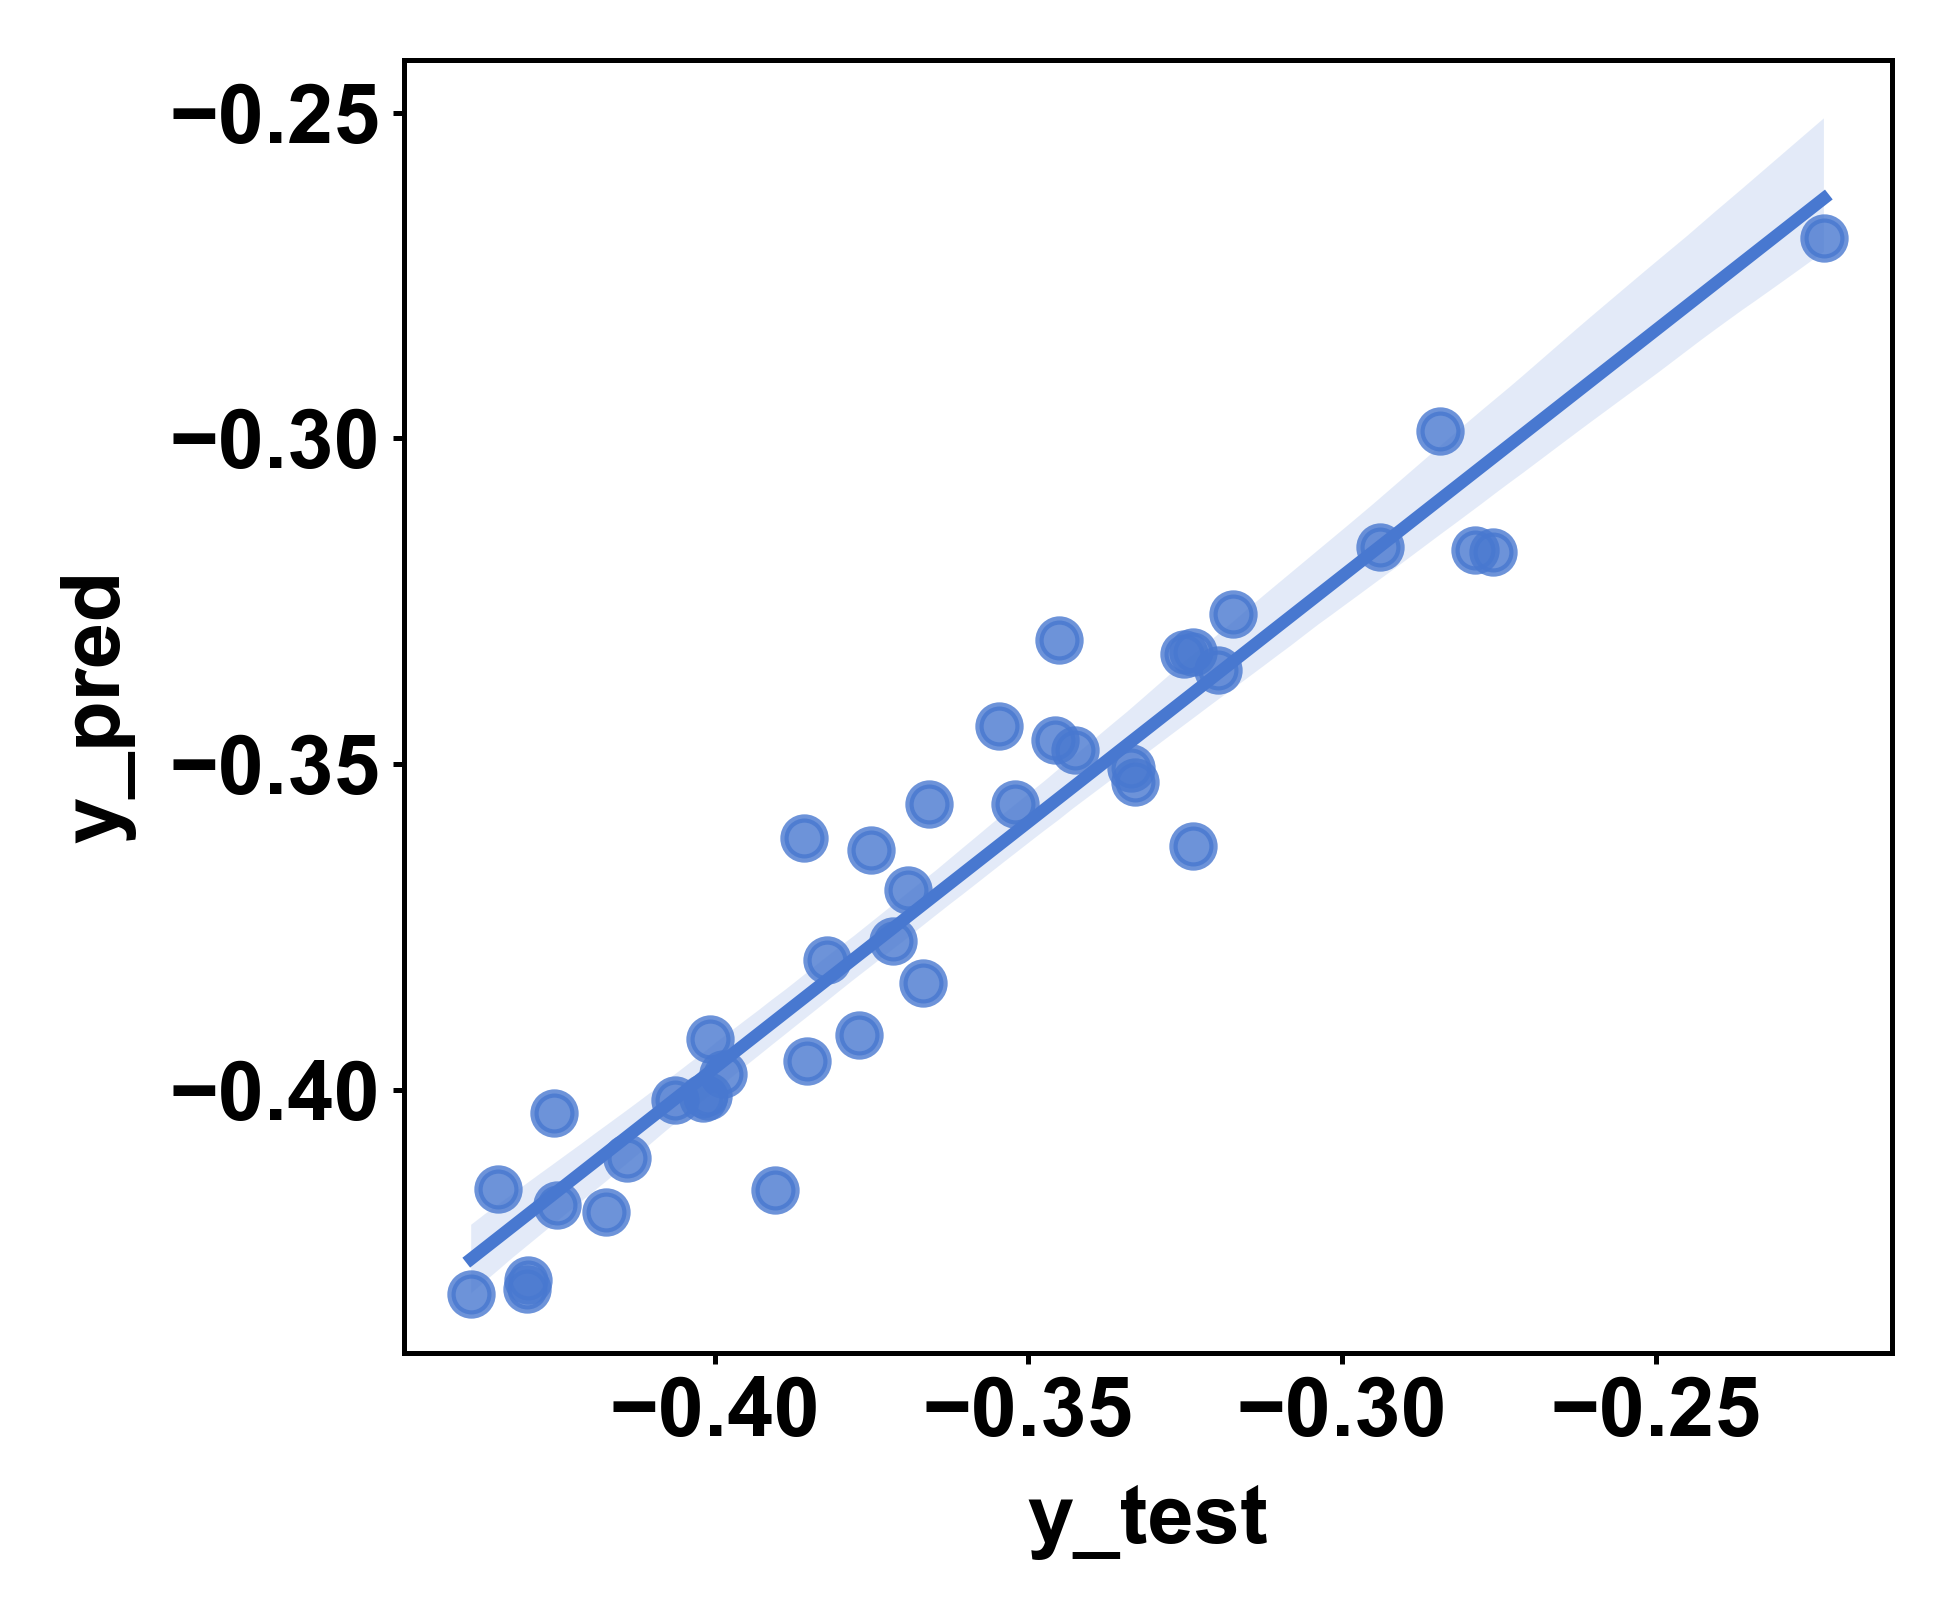

In [8]:
from sklearn.ensemble import RandomForestRegressor
RFR_default = RandomForestRegressor(random_state=1)
RFR_default.fit(X_train_standard_np,y_train_np)
y_pred_default=RFR_default.predict(X_test_standard_np)


x_1,y_1=pd.Series(y_test_np,name='y_test'),pd.Series(y_pred_default,name='y_pred')
sns.regplot(x=x_1,y=y_1)
plt.show


#rmse_log = np.sqrt(mean_squared_error(np.log(y_test),np.log(abs(y_pred))))
rmse = np.sqrt(mean_squared_error(y_test_np,y_pred_default))
r2 = r2_score(y_test_np,y_pred_default)


print(f'Mean Absolute Error MAE: {mean_absolute_error(y_test_np,y_pred_default)}')
print ('test rmse scores : ',rmse)
print ('test R2 scores : ',r2)

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [10]:
RFR_GS=RandomForestRegressor(n_jobs=-1, random_state=1) 


max_depth = [5, 6, 7, 8]
n_estimators =[50, 60, 70, 80]
max_features = ["sqrt", "log2"]
min_samples_leaf = [1, 2, 3]
min_samples_split = [2, 3, 4, 5]
bootstrap = [True, False]

param_grid = {
    "max_features": max_features,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
    "max_depth": max_depth,
    "n_estimators": n_estimators
}




gs= GridSearchCV(estimator=RFR_GS,
                param_grid=param_grid,
                scoring='r2',
                return_train_score=True,
                cv=5,
                n_jobs=-1)


gs=gs.fit(X_train_standard_np, y_train_np)

print(gs.best_score_)
print(gs.best_params_)

bs_v=gs.best_params_['bootstrap']
max_f_v=gs.best_params_['max_features']
leaf_v=gs.best_params_['min_samples_leaf']
split_v=gs.best_params_['min_samples_split']
depth_v=gs.best_params_['max_depth']
estimator_v=gs.best_params_['n_estimators']

0.9061544105518596
{'bootstrap': False, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold


RFR_KF = RandomForestRegressor(n_estimators=estimator_v, max_depth=depth_v, bootstrap=bs_v, max_features=max_f_v, min_samples_leaf=leaf_v,
                            min_samples_split=split_v, n_jobs=-1, random_state=1)


kf = KFold(n_splits=5)


rmse_scores = []
r2_scores = []
mae_scores = []
feature_imp_set=[]


for train_indices, test_indices in kf.split(X_train_standard_np):
    X_train_k, X_test_k = X_train_standard_np[train_indices], X_train_standard_np[test_indices]
    y_train_k, y_test_k = y_train_np[train_indices], y_train_np[test_indices]
    RFR_KF.fit(X_train_k,y_train_k)
    y_pred_k=RFR_KF.predict(X_test_k)
    feature_imp=RFR_KF.feature_importances_
    feature_imp_set.append(feature_imp) 

    rmse = np.sqrt(mean_squared_error(y_test_k,y_pred_k))
    rmse_scores.append(rmse)
    r2 = r2_score(y_test_k,y_pred_k)
    r2_scores.append(r2)
    mae = mean_absolute_error(y_test_k,y_pred_k)
    mae_scores.append(mae)


print (feature_imp_set)
print ('mae scores : ',mae_scores)
print (f'average mae score : {np.mean(mae_scores)}')    
print ('rmse scores : ',rmse_scores)
print (f'average rmse score : {np.mean(rmse_scores)}')
print ('R2 scores : ',r2_scores)
print (f'average R2 score : {np.mean(r2_scores)}')

[array([0.13870053, 0.46997299, 0.10049185, 0.17666336, 0.11417127]), array([0.15018557, 0.45508084, 0.08158976, 0.19790839, 0.11523545]), array([0.12771429, 0.50536958, 0.10744378, 0.14493362, 0.11453873]), array([0.13900773, 0.47453911, 0.07358083, 0.21327406, 0.09959827]), array([0.10868479, 0.45318565, 0.0946181 , 0.21950738, 0.12400409])]
mae scores :  [0.006050069049945261, 0.009216945933899174, 0.009356224332001225, 0.011264421864204129, 0.009177970726893374]
average mae score : 0.009013126381388632
rmse scores :  [0.007524528430961623, 0.011256872313713829, 0.012580091613176879, 0.014763690956694334, 0.011381906220907846]
average rmse score : 0.011501417907090902
R2 scores :  [0.9577020089569729, 0.9121423337895238, 0.8870413497220175, 0.8746195318140656, 0.8992668284767179]
average R2 score : 0.9061544105518596


In [12]:
data = pd.read_excel('data_final.xlsx')


#data = data.astype(float)
#data.info()


X_all = data.iloc[:,1:6]
y_all = data.iloc[:,0]


X_all_np=X_all.values
y_all_np=y_all.values

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler_all = StandardScaler()
RFR_all = RandomForestRegressor(n_estimators=estimator_v, max_depth=depth_v, bootstrap=bs_v, max_features=max_f_v, min_samples_leaf=leaf_v,
                            min_samples_split=split_v, n_jobs=-1, random_state=1)


feature_imp_set=[]


train_rmse_scores = []
train_r2_scores = []
train_mae_scores = []

test_rmse_scores = []
test_r2_scores = []
test_mae_scores = []

final_test_rmse_scores = []
final_test_r2_scores = []
final_test_mae_scores = []


n = 20


for i in range(n):
    X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=True, random_state=i)

    scaler_all.fit(X_all_train)
    X_all_train_standard = scaler_all.transform(X_all_train)
    X_all_test_standard = scaler_all.transform(X_all_test)
    X_final_test_standard_all = scaler_all.transform(X_final_test)
    
    RFR_all.fit(X_all_train_standard, y_all_train)

    y_all_train_pred = RFR_all.predict(X_all_train_standard)
    train_rmse = np.sqrt(mean_squared_error(y_all_train, y_all_train_pred))
    train_rmse_scores.append(train_rmse)
    train_r2 = r2_score(y_all_train, y_all_train_pred)
    train_r2_scores.append(train_r2)
    train_mae = mean_absolute_error(y_all_train, y_all_train_pred)
    train_mae_scores.append(train_mae)

    y_all_test_pred = RFR_all.predict(X_all_test_standard)
    test_rmse = np.sqrt(mean_squared_error(y_all_test, y_all_test_pred))
    test_rmse_scores.append(test_rmse)
    test_r2 = r2_score(y_all_test, y_all_test_pred)
    test_r2_scores.append(test_r2)
    test_mae = mean_absolute_error(y_all_test, y_all_test_pred)
    test_mae_scores.append(test_mae)

    y_final_test_pred_all = RFR_all.predict(X_final_test_standard_all)
    test_rmse = np.sqrt(mean_squared_error(y_final_test_np, y_final_test_pred_all))
    final_test_rmse_scores.append(test_rmse)
    test_r2 = r2_score(y_final_test_np, y_final_test_pred_all)
    final_test_r2_scores.append(test_r2)
    test_mae = mean_absolute_error(y_final_test_np, y_final_test_pred_all)
    final_test_mae_scores.append(test_mae)

    feature_imp=RFR_all.feature_importances_
    feature_imp_set.append(feature_imp)



results_dict = {
    'method': ['RFR'] * (3 * n),
    'set_type': ['Train'] * n + ['Test'] * n + ['Final_Test'] * n,
    'MAE': train_mae_scores + test_mae_scores + final_test_mae_scores,
    'RMSE': train_rmse_scores + test_rmse_scores + final_test_rmse_scores,
    'R2': train_r2_scores + test_r2_scores + final_test_r2_scores
}
results_df = pd.DataFrame(results_dict)

excel_filename = 'model_evaluation_results_5fea.xlsx'
results_df.to_excel(excel_filename, index=False)

In [14]:
print('train set')
print(f'Average MAE score: {np.mean(train_mae_scores):.4f} ± {np.std(train_mae_scores):.4f}')
print(f'Average RMSE score: {np.mean(train_rmse_scores):.4f} ± {np.std(train_rmse_scores):.4f}')
print(f'Average R2 score: {np.mean(train_r2_scores):.4f} ± {np.std(train_r2_scores):.4f}')

print('\ntest set')
print(f'Average MAE score: {np.mean(test_mae_scores):.4f} ± {np.std(test_mae_scores):.4f}')
print(f'Average RMSE score: {np.mean(test_rmse_scores):.4f} ± {np.std(test_rmse_scores):.4f}')
print(f'Average R2 score: {np.mean(test_r2_scores):.4f} ± {np.std(test_r2_scores):.4f}')

print('\nindependent test set')
print(f'Average MAE score: {np.mean(final_test_mae_scores):.4f} ± {np.std(final_test_mae_scores):.4f}')
print(f'Average RMSE score: {np.mean(final_test_rmse_scores):.4f} ± {np.std(final_test_rmse_scores):.4f}')
print(f'Average R2 score: {np.mean(final_test_r2_scores):.4f} ± {np.std(final_test_r2_scores):.4f}')

print(f'\nResults have been saved to {excel_filename}')


print('\nDataFrame preview:')
print(results_df.head())



print('best test set')
min_mae = min(test_mae_scores)
min_mae_index = test_mae_scores.index(min_mae)
print('min MAE score:', min_mae, '    ', 'random_state=', min_mae_index)

min_rmse = min(test_rmse_scores)
min_rmse_index = test_rmse_scores.index(min_rmse)
print('min RMSE score:', min_rmse, '    ', 'random_state=', min_rmse_index)

max_r2 = max(test_r2_scores)
max_r2_index = test_r2_scores.index(max_r2)
print('max R2 score:', max_r2, '    ', 'random_state=', max_r2_index)

print('independent test set')
final_min_mae = min(final_test_mae_scores)
final_min_mae_index = final_test_mae_scores.index(final_min_mae)
print('min MAE score:', final_min_mae, '    ', 'random_state=', final_min_mae_index)

final_min_rmse = min(final_test_rmse_scores)
final_min_rmse_index = final_test_rmse_scores.index(final_min_rmse)
print('min RMSE score:', final_min_rmse, '    ', 'random_state=', final_min_rmse_index)

final_max_r2 = max(final_test_r2_scores)
final_max_r2_index = final_test_r2_scores.index(final_max_r2)
print('maxc R2 score:', final_max_r2, '    ', 'random_state=', final_max_r2_index)

train set
Average MAE score: 0.0014 ± 0.0001
Average RMSE score: 0.0019 ± 0.0001
Average R2 score: 0.9977 ± 0.0004

test set
Average MAE score: 0.0094 ± 0.0016
Average RMSE score: 0.0123 ± 0.0019
Average R2 score: 0.9094 ± 0.0282

independent test set
Average MAE score: 0.0106 ± 0.0008
Average RMSE score: 0.0137 ± 0.0010
Average R2 score: 0.7303 ± 0.0375

Results have been saved to model_evaluation_results_5fea.xlsx

DataFrame preview:
  method set_type       MAE      RMSE        R2
0    RFR    Train  0.001314  0.001857  0.997837
1    RFR    Train  0.001394  0.001906  0.997492
2    RFR    Train  0.001547  0.002216  0.996914
3    RFR    Train  0.001293  0.001816  0.997930
4    RFR    Train  0.001165  0.001671  0.998193
best test set
min MAE score: 0.006479919585110135      random_state= 0
min RMSE score: 0.009132536371799735      random_state= 0
max R2 score: 0.9564983848096557      random_state= 0
independent test set
min MAE score: 0.009073458813732754      random_state= 2
min RMSE sc

train Mean Absolute Error MAE: 0.0015470656872693797
train rmse scores :  0.0022164586115510647
train R2 scores :  0.9969137064427973


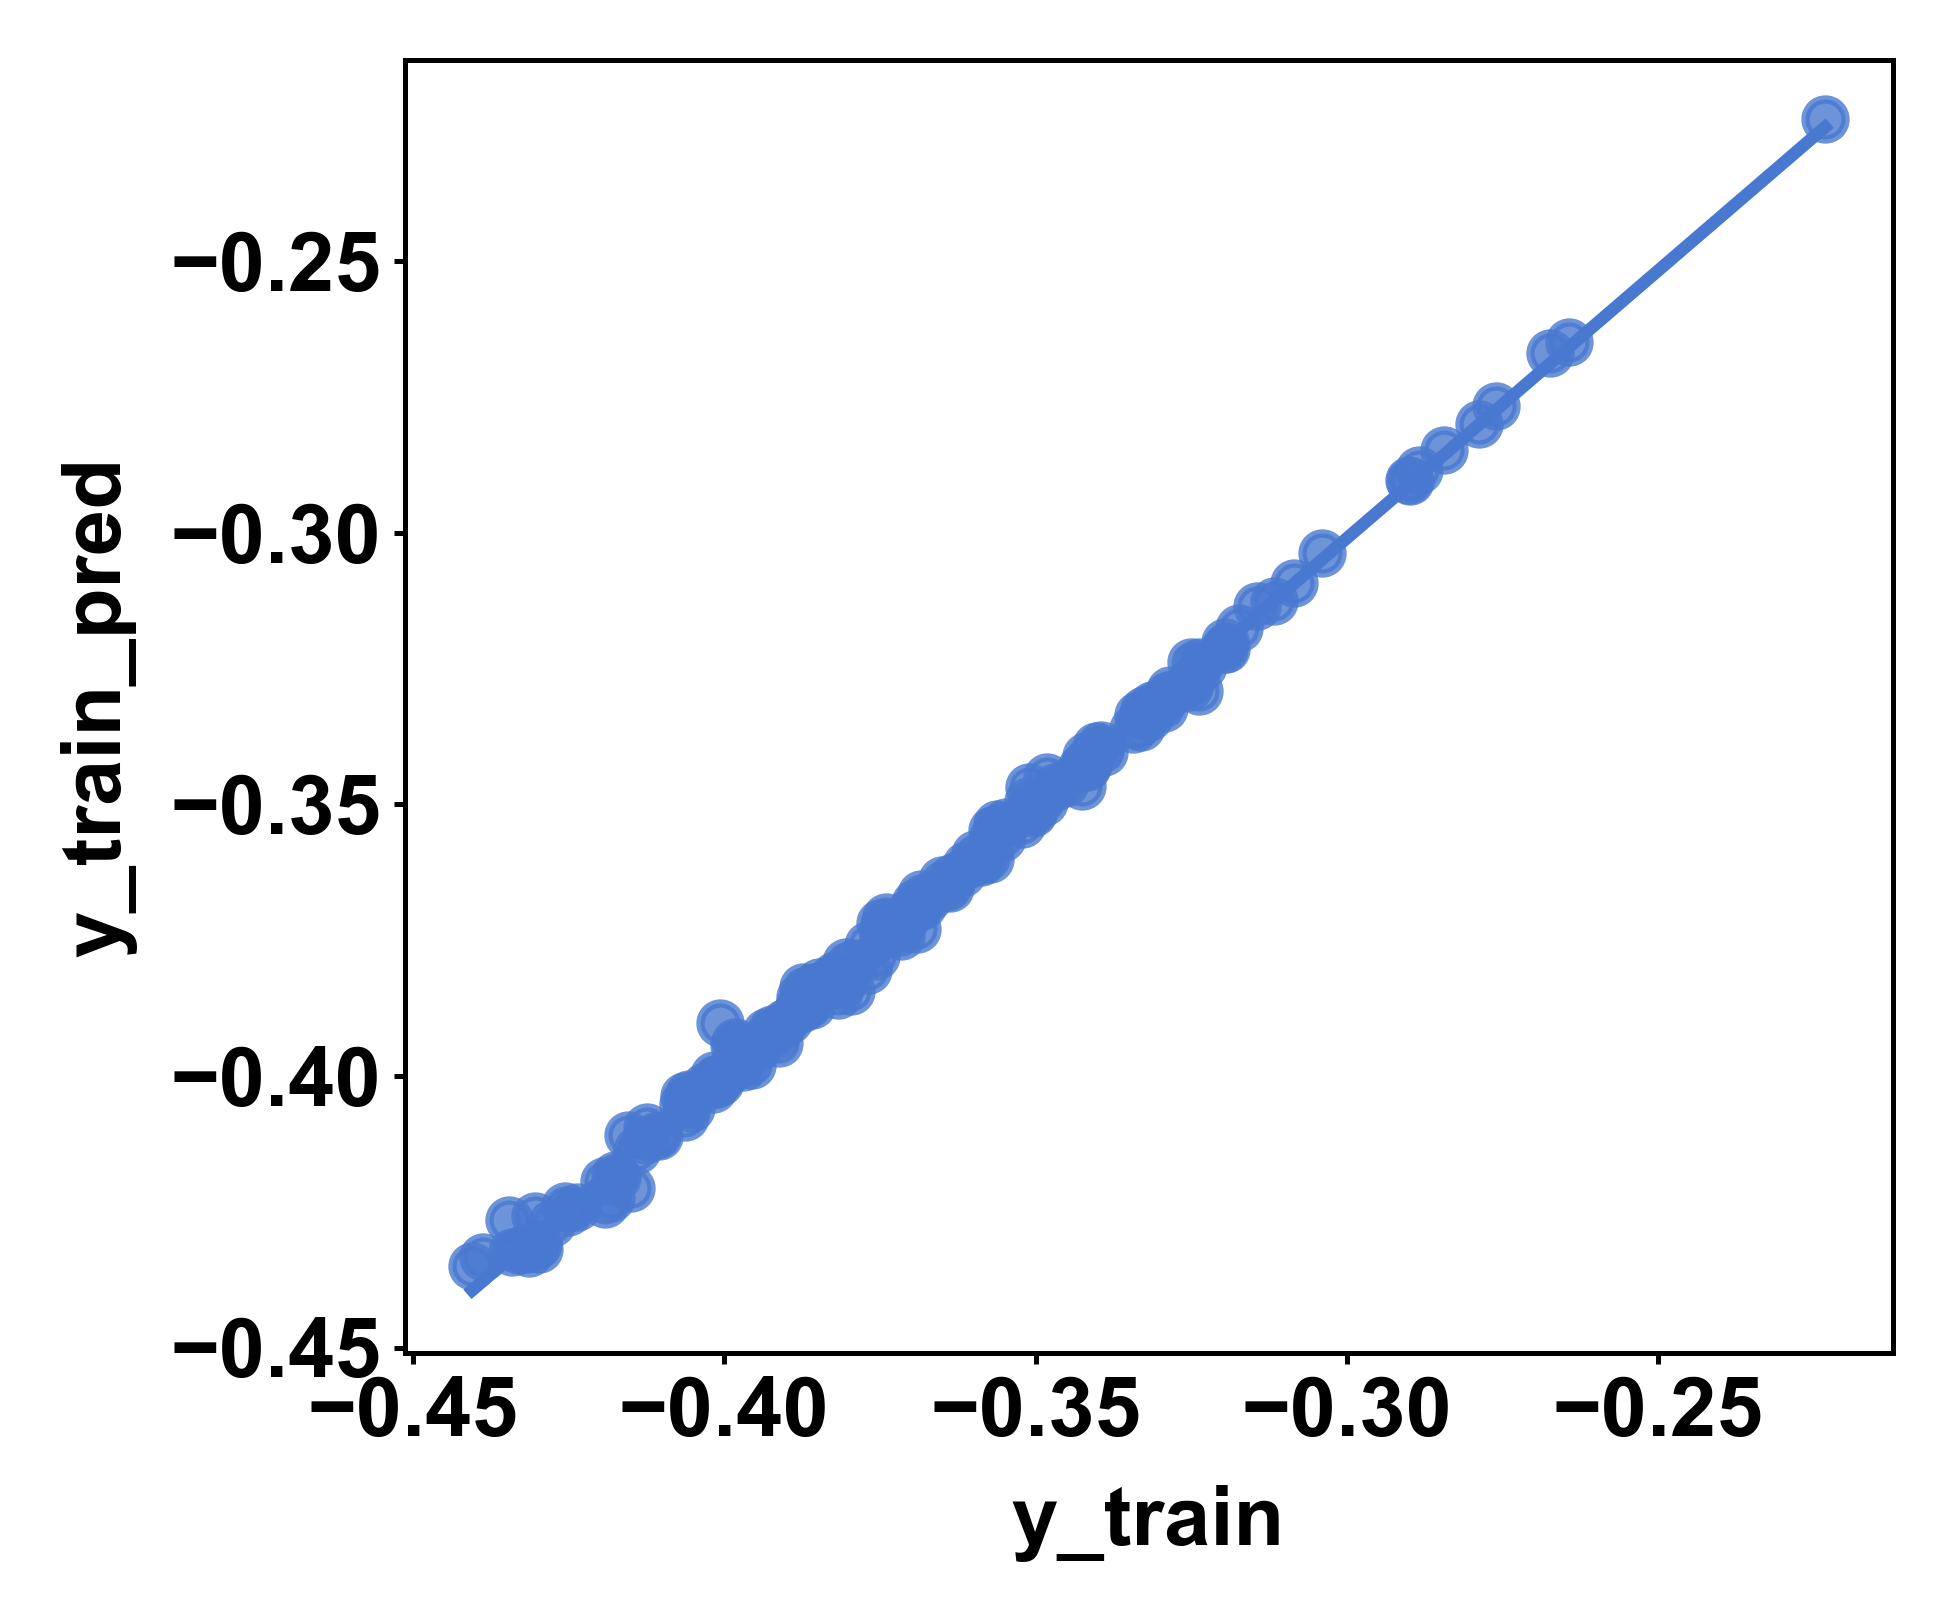

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

max_index=final_max_r2_index

X_train_best,X_test_best,y_train_best,y_test_best = train_test_split(X_all,y_all,test_size=0.2,shuffle=True,random_state=max_index) 


scaler_best = StandardScaler()
scaler_best.fit(X_train_best)
X_train_best_standard = scaler_best.transform(X_train_best)
X_test_best_standard = scaler_best.transform(X_test_best)
X_final_test_standard_best = scaler_best.transform(X_final_test)


RFR_best = RandomForestRegressor(n_estimators=estimator_v, max_depth=depth_v, bootstrap=bs_v, max_features=max_f_v, min_samples_leaf=leaf_v,
                            min_samples_split=split_v, n_jobs=-1, random_state=1)
RFR_best.fit(X_train_best_standard, y_train_best)
y_train_best_pred=RFR_best.predict(X_train_best_standard)

x_best_1,y_best_1=pd.Series(y_train_best,name='y_train'),pd.Series(y_train_best_pred,name='y_train_pred')
sns.regplot(x=x_best_1,y=y_best_1)
plt.show

#rmse_log = np.sqrt(mean_squared_error(np.log(y_test),np.log(abs(y_pred))))
rmse = np.sqrt(mean_squared_error(y_train_best, y_train_best_pred))
r2 = r2_score(y_train_best, y_train_best_pred)


print(f'train Mean Absolute Error MAE: {mean_absolute_error(y_train_best,y_train_best_pred)}')
print ('train rmse scores : ',rmse)
print ('train R2 scores : ',r2)

test Mean Absolute Error MAE: 0.011198980047382507
test rmse scores :  0.014704156382745913
test R2 scores :  0.8866072899955972


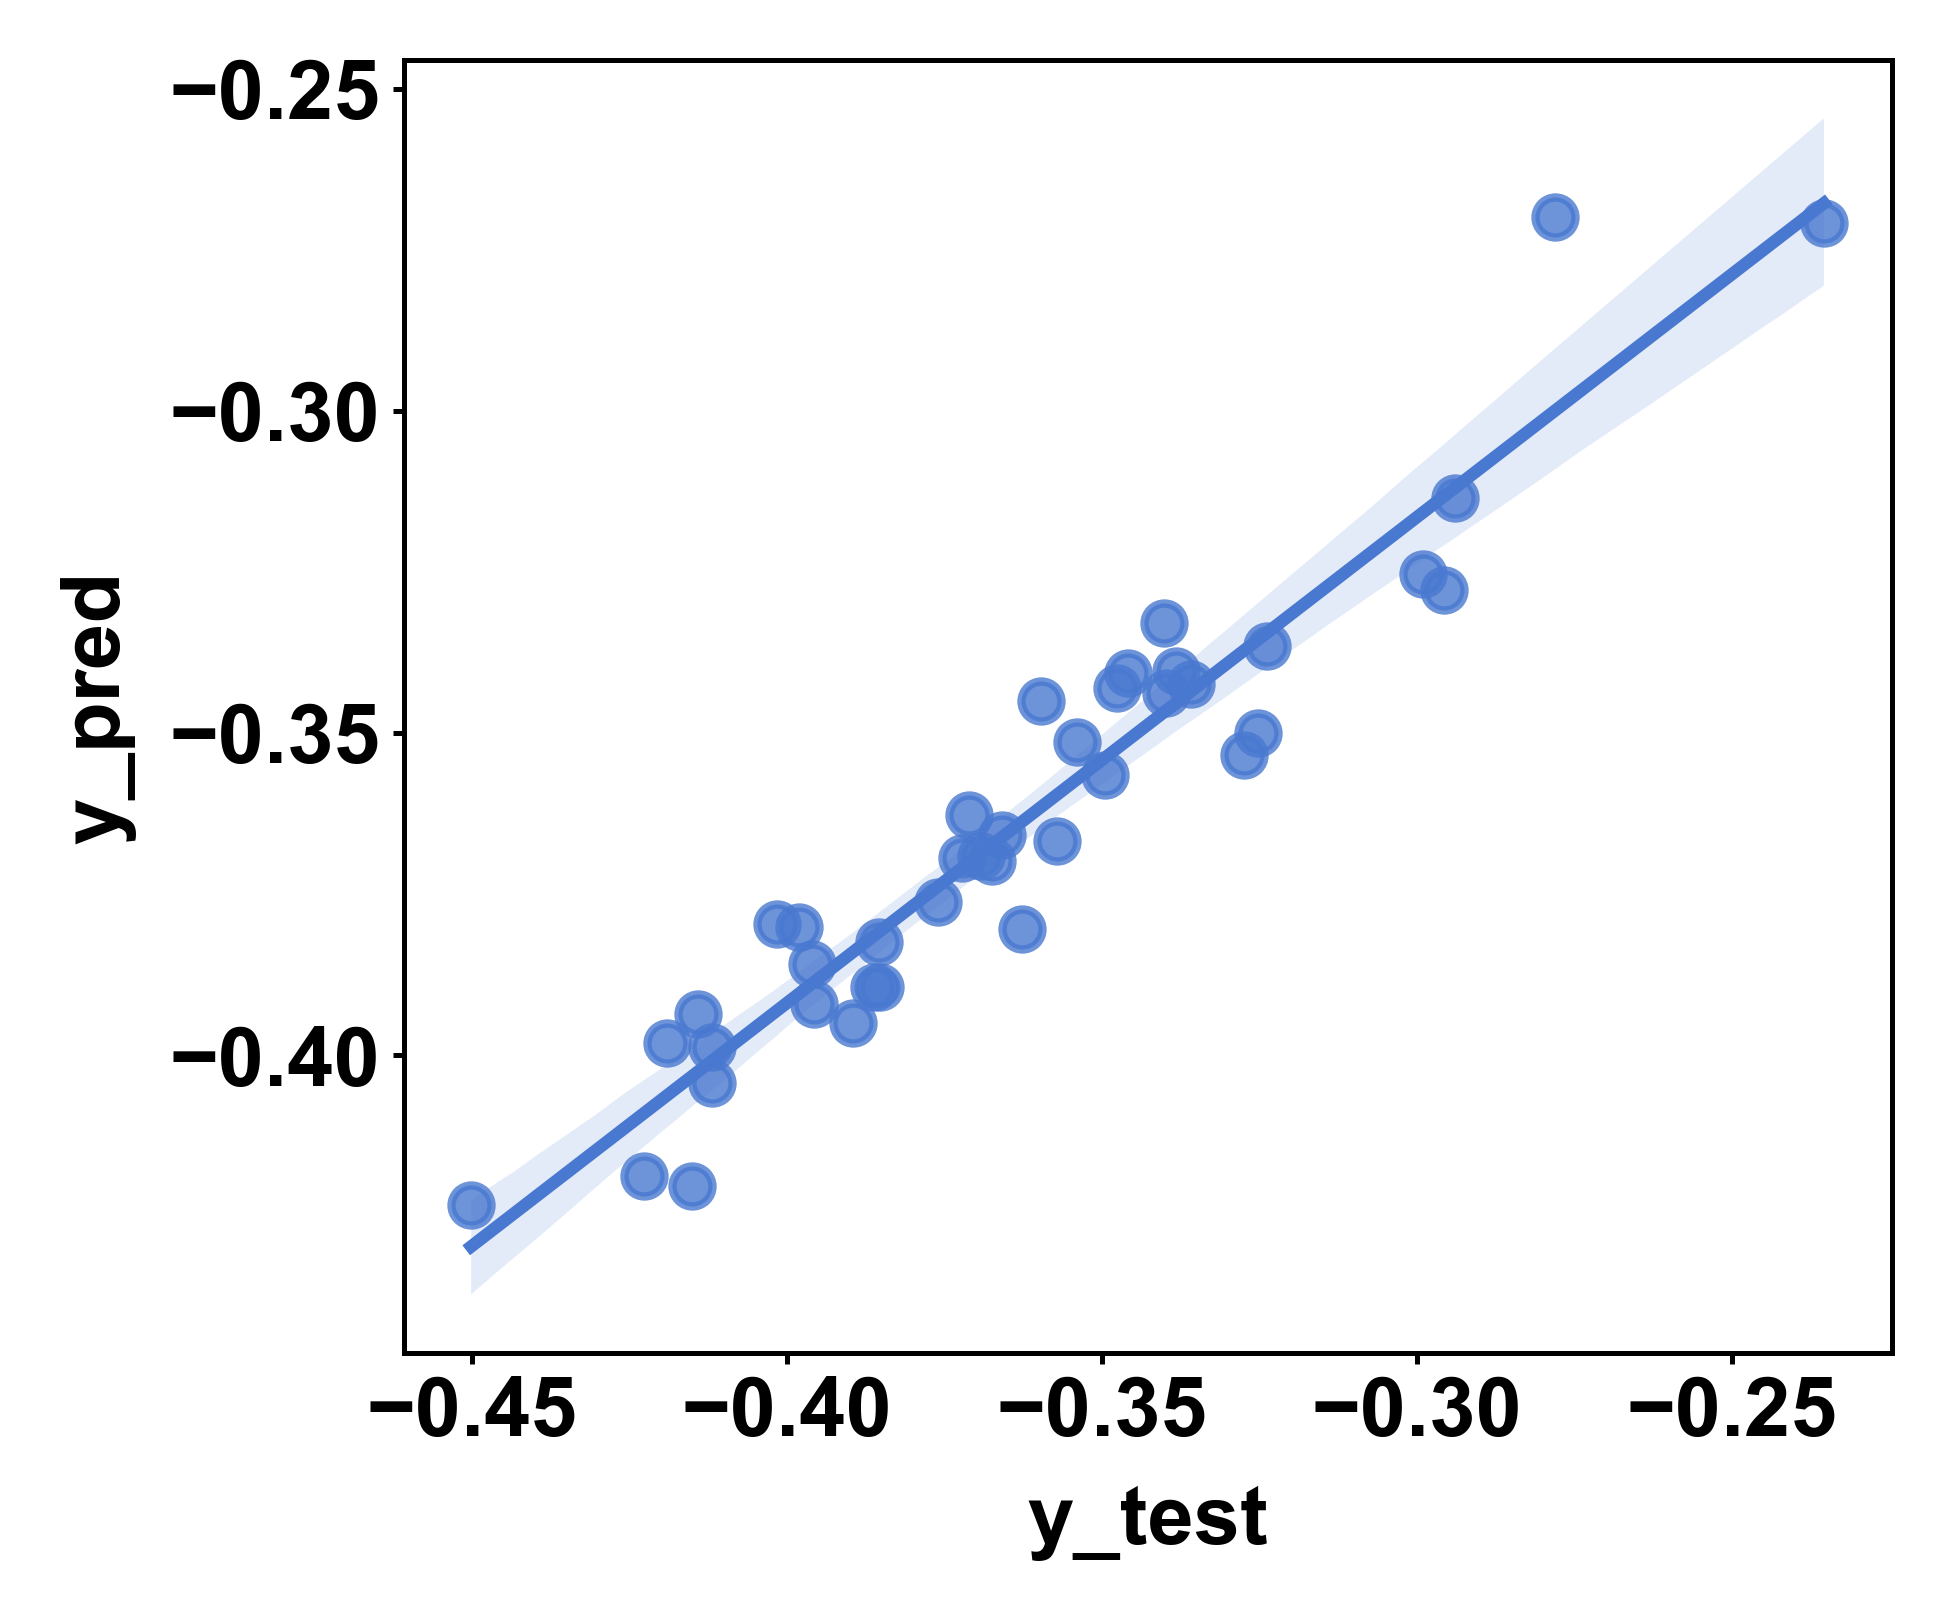

In [16]:
y_test_best_pred=RFR_best.predict(X_test_best_standard)


x_best_2,y_best_2=pd.Series(y_test_best,name='y_test'),pd.Series(y_test_best_pred,name='y_pred')  #注意所用变量名不要有冲突
sns.regplot(x=x_best_2,y=y_best_2)
plt.show

rmse = np.sqrt(mean_squared_error(y_test_best,y_test_best_pred))  #用log缩小
r2 = r2_score(y_test_best,y_test_best_pred)


print(f'test Mean Absolute Error MAE: {mean_absolute_error(y_test_best,y_test_best_pred)}')
print ('test rmse scores : ',rmse)
print ('test R2 scores : ',r2)

test Mean Absolute Error MAE: 0.009073458813732765
test rmse scores :  0.0109563466869667
test R2 scores :  0.8273874086162887


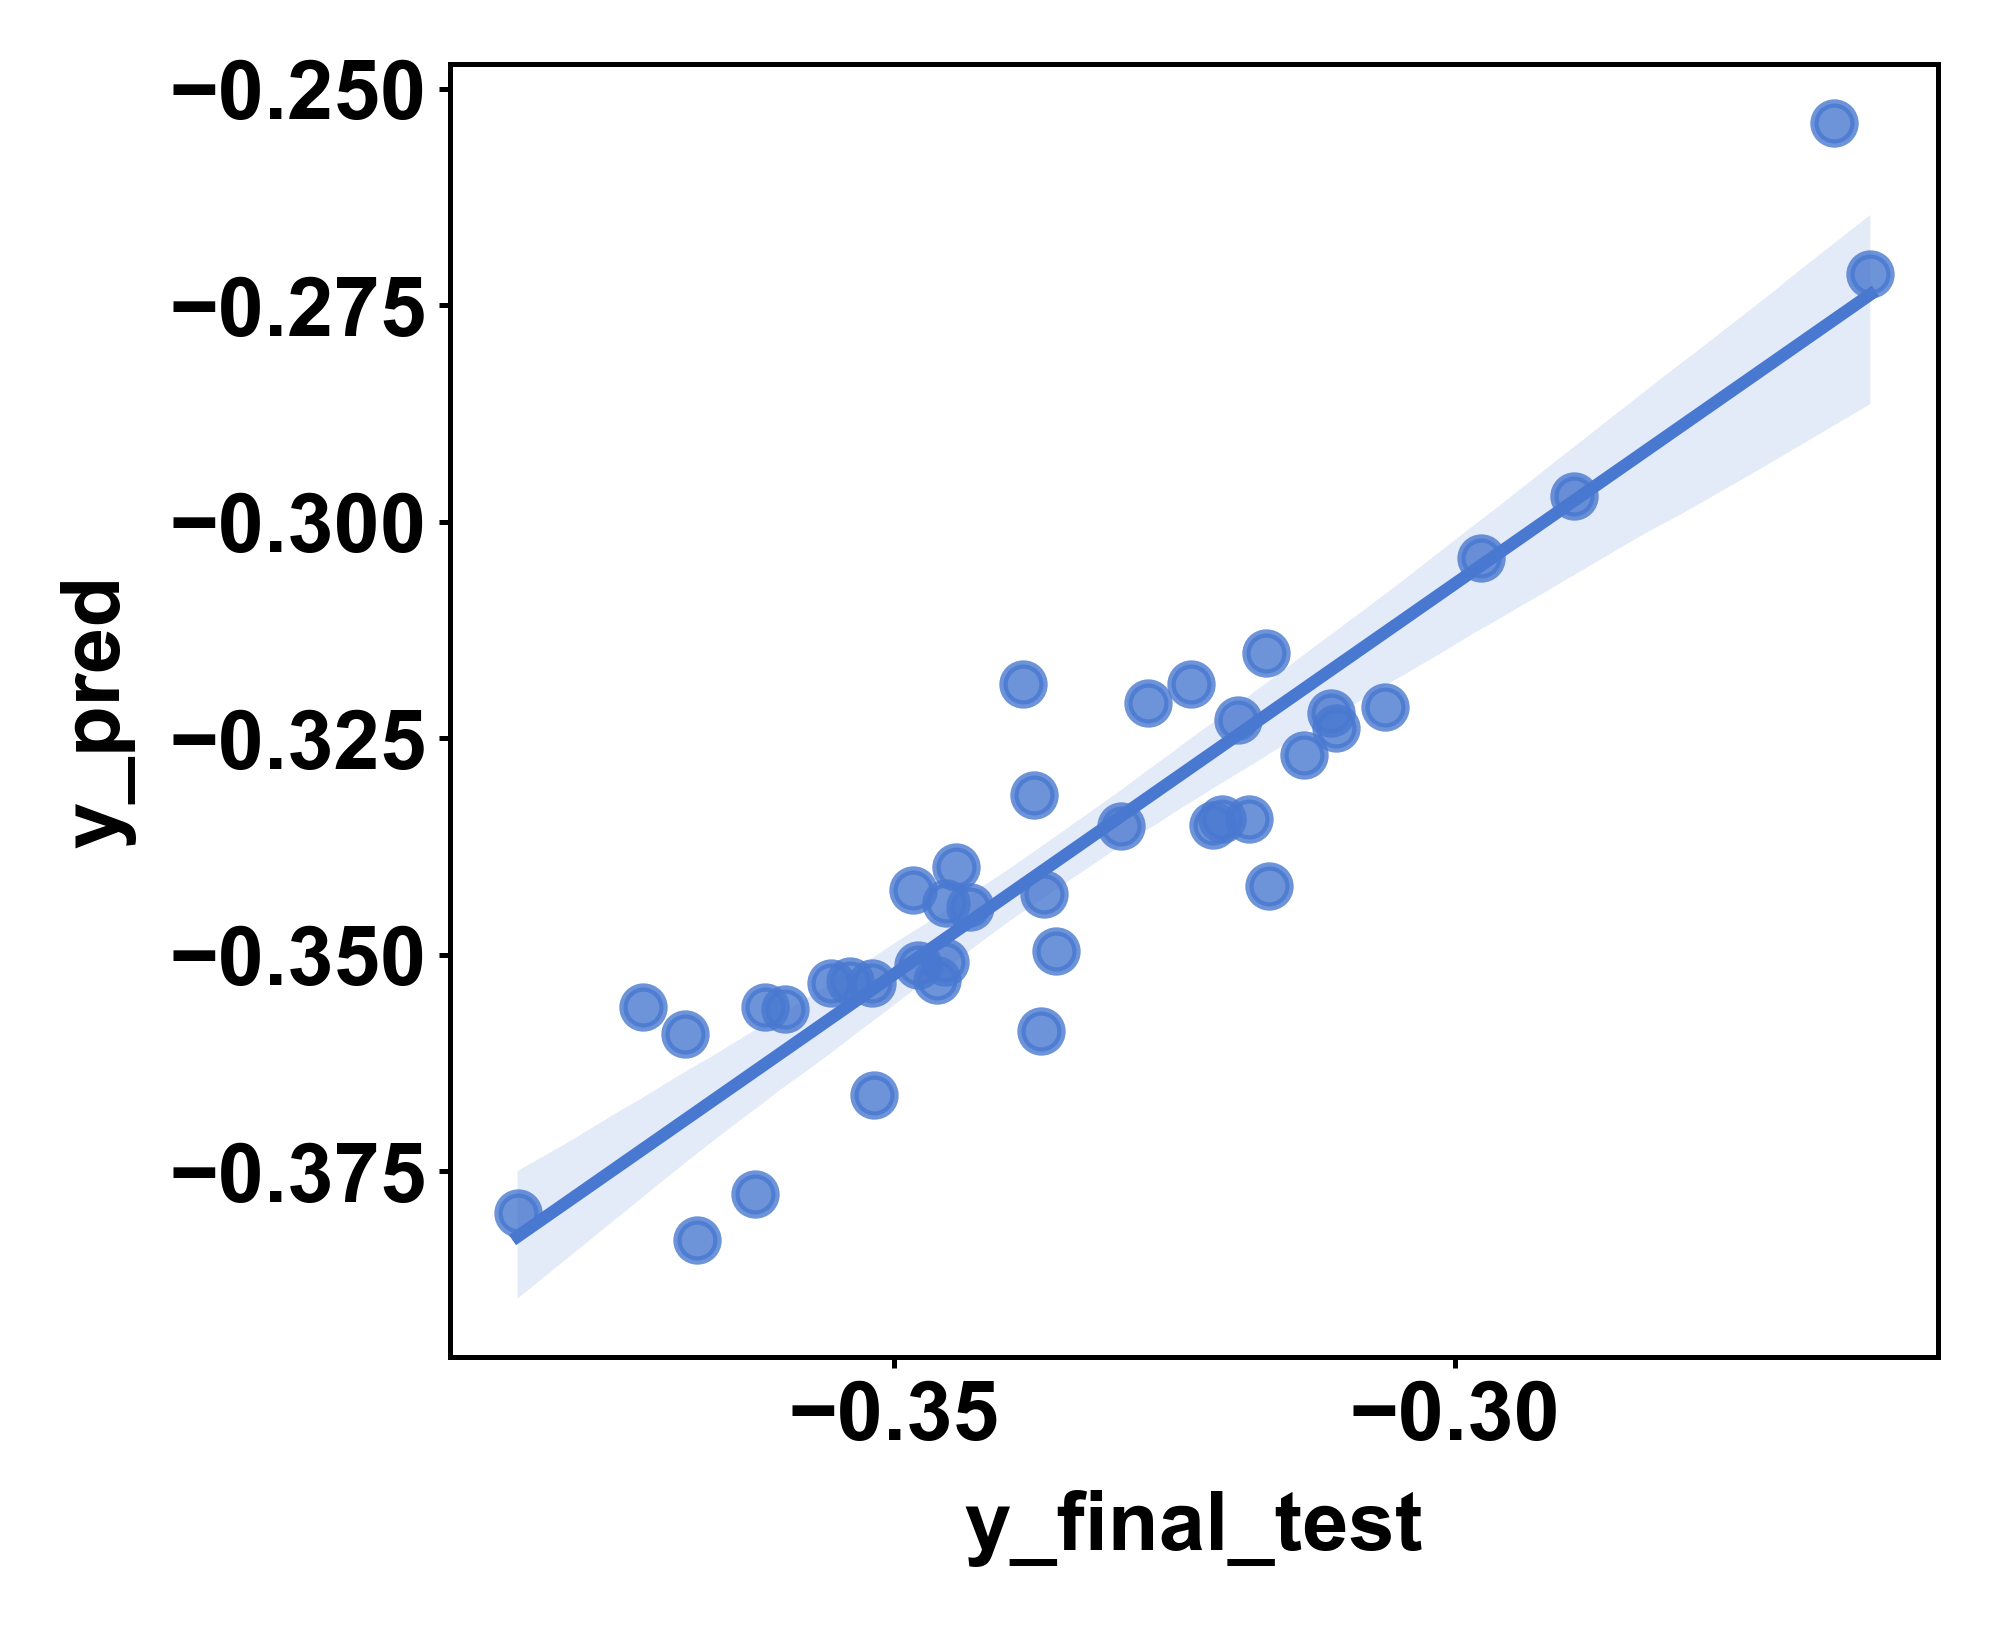

In [17]:
y_final_test_best_pred=RFR_best.predict(X_final_test_standard_best)


x_best_3,y_best_3=pd.Series(y_final_test_np,name='y_final_test'),pd.Series(y_final_test_best_pred,name='y_pred')  #注意所用变量名不要有冲突
sns.regplot(x=x_best_3,y=y_best_3)
plt.show

rmse = np.sqrt(mean_squared_error(y_final_test_np,y_final_test_best_pred))  #用log缩小
r2 = r2_score(y_final_test_np,y_final_test_best_pred)


print(f'test Mean Absolute Error MAE: {mean_absolute_error(y_final_test_np,y_final_test_best_pred)}')
print ('test rmse scores : ',rmse)
print ('test R2 scores : ',r2)